In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [3]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [4]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [5]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [6]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [7]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [8]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [9]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
# ------------------ Time-LLM (Causal Transformer) ------------------
class TimeLLM(nn.Module):
    def __init__(self, n_features, d_model=128, n_heads=4, num_layers=3, dropout=0.1):
        super().__init__()
        self.input_linear = nn.Linear(n_features, d_model)
        encoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerDecoder(encoder_layer, num_layers=num_layers)
        self.output_linear = nn.Linear(d_model, 1)  # Predict next value

    def forward(self, x):
        x_embed = self.input_linear(x)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(x_embed.size(1)).to(x.device)
        out = self.transformer(tgt=x_embed, memory=x_embed, tgt_mask=causal_mask)
        return self.output_linear(out)[:, -1, 0]  # predict next step


In [11]:
# ------------------ Dataset Preparation ------------------
def create_autoregressive_sequences(X_data, y_data, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_len):
        X_seq.append(X_data.iloc[i:i+seq_len].values)
        y_seq.append(y_data.iloc[i+seq_len])
    return np.array(X_seq), np.array(y_seq)


In [12]:
# ------------------ Inference Function (Autoregressive Forecast) ------------------
def autoregressive_forecast(model, scaler, X_test, features, seq_len, forecast_horizon):
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)
    X_test_np = X_test_scaled.values

    forecasts = []
    for i in tqdm(range(len(X_test_np) - seq_len - forecast_horizon), desc="Forecasting"):
        input_window = X_test_np[i:i+seq_len].copy()
        forecast_seq = []
        
        for step in range(forecast_horizon):
            input_tensor = torch.tensor(input_window[np.newaxis,:,:], dtype=torch.float32)
            with torch.no_grad():
                pred = model(input_tensor).item()
            forecast_seq.append(pred)
            
            next_row = np.append(input_window[-1][:-1], pred)
            input_window = np.vstack([input_window[1:], next_row])
        forecasts.append(forecast_seq)
    return np.array(forecasts)


In [13]:
# ------------------ Desequencing Function ------------------
def desequence_autoregressive(predictions, seq_len, forecast_horizon):
    total_length = len(predictions) + seq_len + forecast_horizon - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start_idx = i + seq_len
        end_idx = start_idx + forecast_horizon
        merged_forecast[start_idx:end_idx] += predictions[i]
        count[start_idx:end_idx] += 1

    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]
    return merged_forecast

In [14]:
def autoregressive_forecast_on_sequences(model, X_seq_sliced, forecast_horizon):
    model.eval()
    forecasts = []

    with torch.no_grad():
        for i in range(len(X_seq_sliced)):
            input_seq = torch.tensor(X_seq_sliced[i], dtype=torch.float32).unsqueeze(0)  # add batch dim
            forecast = model(input_seq).numpy()
            forecasts.append(forecast)

    forecasts = np.array(forecasts).squeeze()
    return forecasts


In [15]:
def evaluate_two_timellm_models(
    model_orig, model_aug, scaler, X_test, y_test, features, 
    seq_len, forecast_horizon, time_index=None, start_point=0, end_point=None
):
    # Get predictions for both models
    forecasts_orig = autoregressive_forecast(model_orig, scaler, X_test, features, seq_len, forecast_horizon)
    merged_pred_orig = desequence_autoregressive(forecasts_orig, seq_len, forecast_horizon)

    forecasts_aug = autoregressive_forecast(model_aug, scaler, X_test, features, seq_len, forecast_horizon)
    merged_pred_aug = desequence_autoregressive(forecasts_aug, seq_len, forecast_horizon)

    # Scale test data
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)
    valid_indices = len(X_test_scaled) - seq_len - forecast_horizon
    X_seq, y_seq = create_autoregressive_sequences(X_test_scaled, y_test, seq_len)
    y_seq = y_seq[:valid_indices]  
    merged_true = desequence_autoregressive(np.expand_dims(y_seq, axis=1), seq_len, forecast_horizon)

    # Apply slicing
    merged_true = merged_true[start_point:end_point]
    merged_pred_orig = merged_pred_orig[start_point:end_point]
    merged_pred_aug = merged_pred_aug[start_point:end_point]

    # Metrics
    mse_orig = mean_squared_error(merged_true, merged_pred_orig)
    mae_orig = mean_absolute_error(merged_true, merged_pred_orig)
    rmse_orig = math.sqrt(mse_orig)

    mse_aug = mean_squared_error(merged_true, merged_pred_aug)
    mae_aug = mean_absolute_error(merged_true, merged_pred_aug)
    rmse_aug = math.sqrt(mse_aug)

    print(f"Original Model - MSE: {mse_orig:.4f}, MAE: {mae_orig:.4f}, RMSE: {rmse_orig:.4f}")
    print(f"Augmented Model - MSE: {mse_aug:.4f}, MAE: {mae_aug:.4f}, RMSE: {rmse_aug:.4f}")

    # Prepare time index
    if time_index is not None:
        time_index = time_index[-len(merged_true):]
        plot_range = time_index
    else:
        plot_range = range(len(merged_true))

    if end_point is None:
        end_point = len(merged_true)

    plt.figure(figsize=(16, 6))
    
    # Historical window (before forecast)
    plt.plot(plot_range[start_point:start_point+seq_len], 
             merged_true[start_point:start_point+seq_len], 
             label='Input History', color='blue', linewidth=2)
    
    # Actual future
    plt.plot(plot_range[start_point:end_point], 
             merged_true[start_point:end_point], 
             label='Actual Future', color='black')
    
    # Forecasts
    plt.plot(plot_range[start_point:end_point], 
             merged_pred_orig[start_point:end_point], 
             label='Original Model Forecast', color='red', linestyle='--')
    
    plt.plot(plot_range[start_point:end_point], 
             merged_pred_aug[start_point:end_point], 
             label='Augmented Model Forecast', color='green', linestyle=':')

    # Shade between Actual and Original Forecast (pink)
    plt.fill_between(
        plot_range[start_point:end_point], 
        merged_true[start_point:end_point], 
        merged_pred_orig[start_point:end_point], 
        where=(merged_true[start_point:end_point] >= merged_pred_orig[start_point:end_point]),
        interpolate=True, color='pink', alpha=0.5, label='Error (Actual - Original)'
    )
    plt.fill_between(
        plot_range[start_point:end_point], 
        merged_pred_orig[start_point:end_point], 
        merged_true[start_point:end_point], 
        where=(merged_true[start_point:end_point] < merged_pred_orig[start_point:end_point]),
        interpolate=True, color='pink', alpha=0.5
    )

    # Shade between Original Forecast and Augmented Forecast (light blue)
    plt.fill_between(
        plot_range[start_point:end_point], 
        merged_pred_orig[start_point:end_point], 
        merged_pred_aug[start_point:end_point], 
        where=(merged_pred_aug[start_point:end_point] >= merged_pred_orig[start_point:end_point]),
        interpolate=True, color='lightblue', alpha=0.5, label='Difference (Original - Augmented)'
    )
    plt.fill_between(
        plot_range[start_point:end_point], 
        merged_pred_aug[start_point:end_point], 
        merged_pred_orig[start_point:end_point], 
        where=(merged_pred_aug[start_point:end_point] < merged_pred_orig[start_point:end_point]),
        interpolate=True, color='lightblue', alpha=0.5
    )

    plt.xlabel("Date" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("Time-LLM Forecast Comparison: Original vs Augmented")
    plt.legend()
    plt.grid(True)

    textstr = (
        f'Original Model\nMAE: {mae_orig:.4f}\nRMSE: {rmse_orig:.4f}\n'
        f'Augmented Model\nMAE: {mae_aug:.4f}\nRMSE: {rmse_aug:.4f}'
    )
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()


In [16]:
import joblib

In [39]:
seq_len = 24
forecast_horizon = 12


X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]

X_test = org_test_processed[features].copy()
X_test.index = pd.to_datetime(org_test_processed["Time"])
y_test = org_test_processed[target]

In [42]:
model_path  = "../Models/weights/time_llm_aug_model.pth_5"
torch.load(model_path).keys()

dict_keys(['epoch', 'model_state', 'optimizer_state'])

In [43]:
model_timellm_aug = TimeLLM(len(features))
# Load model state_dict
model_path  = "../Models/weights/time_llm_aug_model.pth_5"
model_timellm_aug.load_state_dict(torch.load(model_path)['model_state'])

# Set model to eval mode (important for inference)
model_timellm_aug.eval()

print("Model loaded successfully.")

scaler_path = '../Models/weights/scaler_timellm_aug.pkl'
scaler_timellm_aug = joblib.load(scaler_path)

print("Scaler loaded successfully.")

Model loaded successfully.
Scaler loaded successfully.


In [44]:
model_timellm_org = TimeLLM(len(features))
# Load model state_dict
model_path  = "../Models/weights/time_llm_org_model.pth_5"
model_timellm_org.load_state_dict(torch.load(model_path))

# Set model to eval mode (important for inference)
model_timellm_org.eval()

print("Model loaded successfully.")

scaler_path = '../Models/weights/scaler_timellm_org.pkl'
scaler_timellm_org = joblib.load(scaler_path)

print("Scaler loaded successfully.")

Model loaded successfully.
Scaler loaded successfully.



Evaluating TimeLLM on test data...


Forecasting: 100%|██████████| 707/707 [00:12<00:00, 55.76it/s]


Original Model - MSE: 0.0032, MAE: 0.0418, RMSE: 0.0568
Augmented Model - MSE: 0.0010, MAE: 0.0258, RMSE: 0.0317


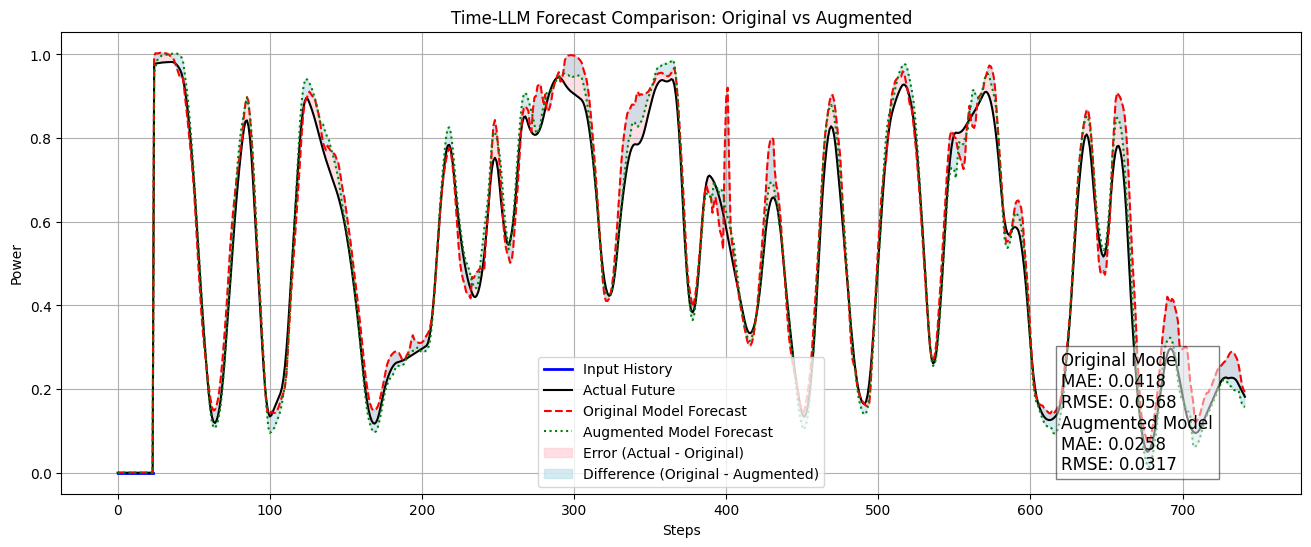

Forecasting: 100%|██████████| 707/707 [00:12<00:00, 58.37it/s]


Original Model - MSE: 0.0027, MAE: 0.0429, RMSE: 0.0515
Augmented Model - MSE: 0.0004, MAE: 0.0168, RMSE: 0.0206


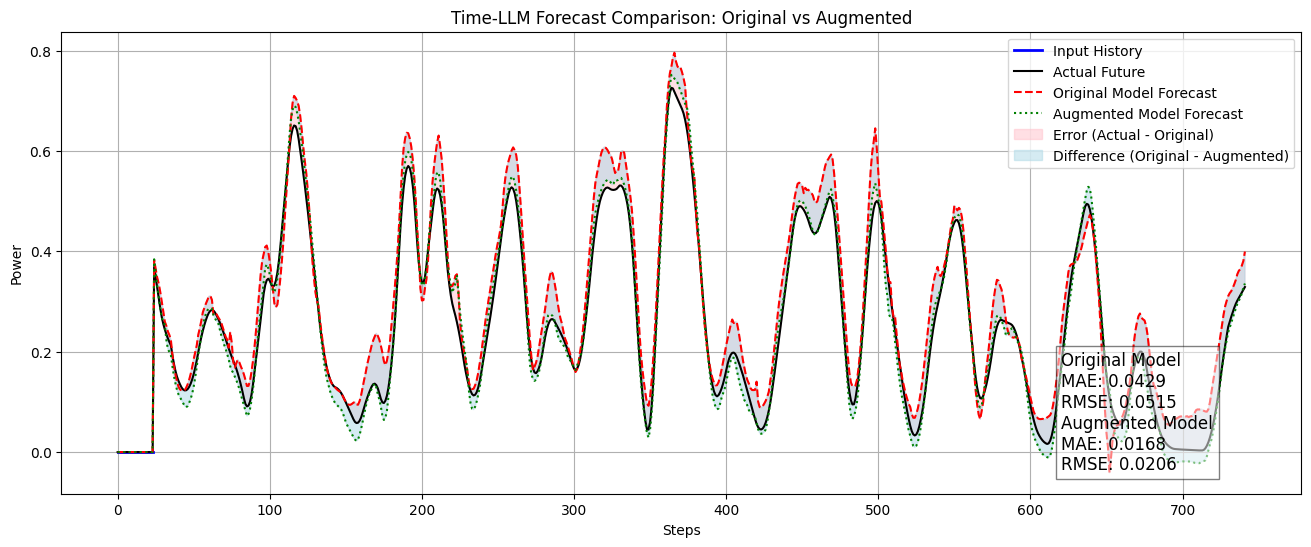

Forecasting: 100%|██████████| 707/707 [00:11<00:00, 58.95it/s]


Original Model - MSE: 0.0068, MAE: 0.0525, RMSE: 0.0825
Augmented Model - MSE: 0.0015, MAE: 0.0300, RMSE: 0.0385


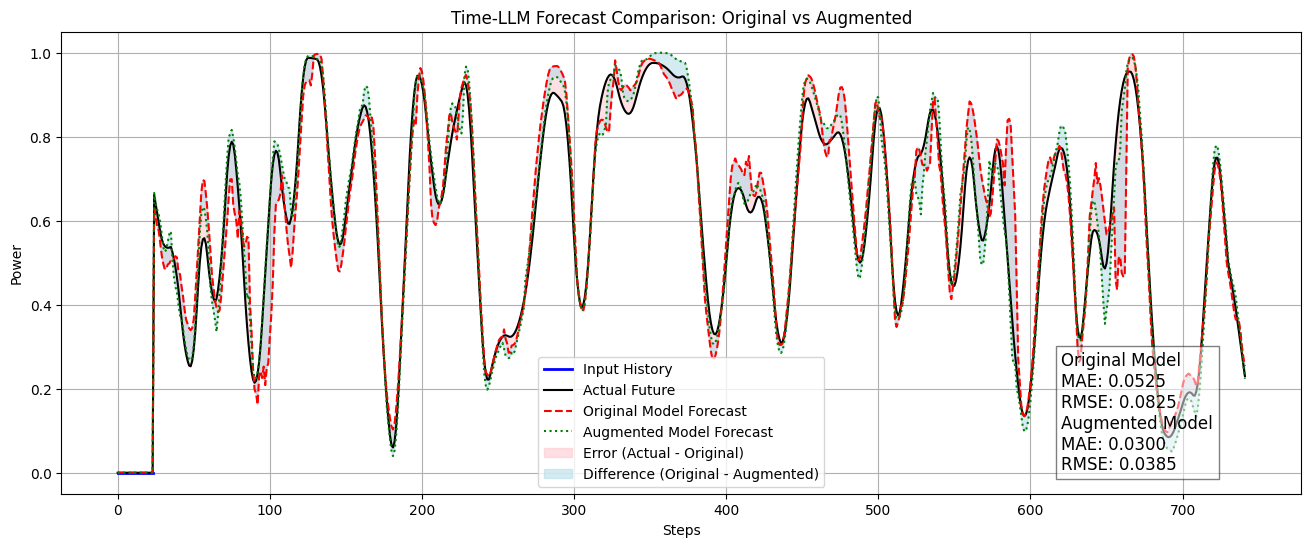

Forecasting: 100%|██████████| 707/707 [00:12<00:00, 57.41it/s]


Original Model - MSE: 0.0038, MAE: 0.0491, RMSE: 0.0612
Augmented Model - MSE: 0.0007, MAE: 0.0203, RMSE: 0.0262


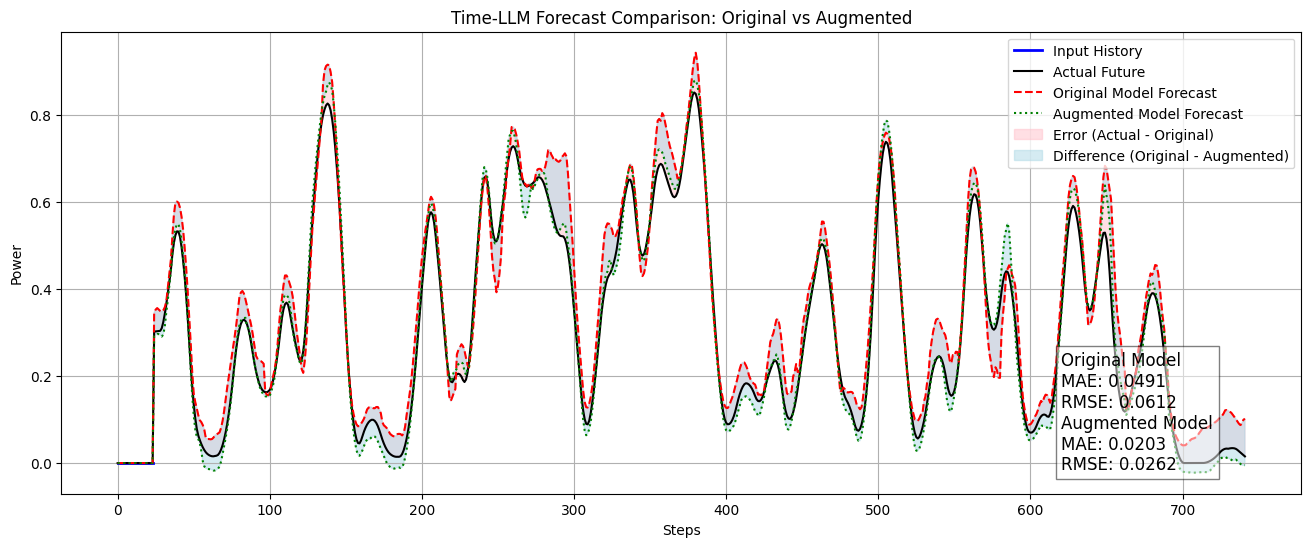

In [45]:
print("\nEvaluating TimeLLM on test data...")
start_point=7991
end_point=8734
evaluate_two_timellm_models(model_orig=model_timellm_org,model_aug=model_timellm_aug, scaler= scaler_timellm_aug, X_test= X_test[start_point:end_point], y_test= y_test[start_point:end_point],features= features, seq_len=seq_len, forecast_horizon=forecast_horizon)
start_point=16726
end_point=17469
evaluate_two_timellm_models(model_orig=model_timellm_org,model_aug= model_timellm_aug, scaler= scaler_timellm_aug,X_test=  X_test[start_point:end_point],y_test= y_test[start_point:end_point],features= features, seq_len=seq_len, forecast_horizon=forecast_horizon)
start_point=25461
end_point=26204
evaluate_two_timellm_models(model_orig=model_timellm_org,model_aug= model_timellm_aug, scaler= scaler_timellm_aug, X_test= X_test[start_point:end_point],y_test= y_test[start_point:end_point],features= features,seq_len= seq_len, forecast_horizon=forecast_horizon)
start_point=34196
end_point=34939
evaluate_two_timellm_models(model_orig=model_timellm_org,model_aug= model_timellm_aug, scaler= scaler_timellm_aug, X_test= X_test[start_point:end_point],y_test= y_test[start_point:end_point],features= features,seq_len= seq_len, forecast_horizon= forecast_horizon)


In [46]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import torch
import math 

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / np.clip(denominator, 1e-8, None)) * 100


def evaluate_monthly_timemoe_errors(
    model_orig, model_aug, 
    scaler_X, y_train_org,
    X_test, y_test, features,
    seq_len
):
    # Prepare index
    X_test = X_test.copy()
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = X_test.index

    # Scale full test set
    X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), index=X_test.index, columns=features)

    # Inverse scaler for target
    y_scaler = StandardScaler().fit(y_train_org.values.reshape(-1, 1))

    # Location slicing
    total_len = len(X_test)
    n_locations = 4
    loc_size = total_len // n_locations

    results = []

    for loc in range(n_locations):
        start_idx = loc * loc_size
        end_idx = (loc + 1) * loc_size

        # Data for this location
        X_loc = X_test_scaled.iloc[start_idx:end_idx]
        y_loc = y_test.iloc[start_idx:end_idx]

        for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
            y_month = y_loc[df_month.index]

            if len(df_month) < seq_len + 1:
                continue

            # Create sequences
            X_seq, y_seq = create_autoregressive_sequences(df_month[features],y_month, seq_len)
            if len(X_seq) == 0:
                continue

            X_tensor = torch.tensor(X_seq, dtype=torch.float32)

            # Predict
            with torch.no_grad():
                model_orig.eval()
                model_aug.eval()
                preds_orig = model_orig(X_tensor).numpy()
                preds_aug = model_aug(X_tensor).numpy()

            # Inverse transform
            y_true = y_scaler.inverse_transform(y_seq.reshape(-1, 1)).flatten()
            preds_orig_inv = y_scaler.inverse_transform(preds_orig.reshape(-1, 1)).flatten()
            preds_aug_inv = y_scaler.inverse_transform(preds_aug.reshape(-1, 1)).flatten()

            # Compute metrics
            results.append({
                'location': f'Location_{loc+1}',
                'month': month.strftime('%Y-%m'),
                'mae_org': mean_absolute_error(y_true, preds_orig_inv),
                'rmse_org': math.sqrt(mean_squared_error(y_true, preds_orig_inv)),
                'mape_org': mape(y_true, preds_orig_inv),
                'smape_org': smape(y_true, preds_orig_inv),
                'r2_org': r2_score(y_true, preds_orig_inv),
                'mae_aug': mean_absolute_error(y_true, preds_aug_inv),
                'rmse_aug': math.sqrt(mean_squared_error(y_true, preds_aug_inv)),
                'mape_aug': mape(y_true, preds_aug_inv),
                'smape_aug': smape(y_true, preds_aug_inv),
                'r2_aug': r2_score(y_true, preds_aug_inv)
            })

    results_df = pd.DataFrame(results)

    # Monthly average + std across 4 locations
    monthly_summary = results_df.groupby('month').agg({
        'mae_org': ['mean', 'std'],
        'rmse_org': ['mean', 'std'],
        'mape_org': ['mean', 'std'],
        'smape_org': ['mean', 'std'],
        'r2_org': ['mean', 'std'],
        'mae_aug': ['mean', 'std'],
        'rmse_aug': ['mean', 'std'],
        'mape_aug': ['mean', 'std'],
        'smape_aug': ['mean', 'std'],
        'r2_aug': ['mean', 'std'],
    }).reset_index()

    monthly_summary.columns = ['month'] + [f"{col[0]}_{col[1]}" for col in monthly_summary.columns[1:]]

    return results_df, monthly_summary


In [47]:
results_df, monthly_summary = evaluate_monthly_timemoe_errors(
    model_orig=model_timellm_org,
    model_aug=model_timellm_aug,
    scaler_X=scaler_timellm_aug,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    features=features,
    seq_len=seq_len
)


/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_4075/4041930703.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_4075/4041930703.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_4075/4041930703.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_4075/4041930703.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):


In [48]:
results_df

,location,month,mae_org,rmse_org,mape_org,smape_org,r2_org,mae_aug,rmse_aug,mape_aug,smape_aug,r2_aug
0,Location_1,2021-01,0.012733,0.015429,3.065560,3.009470,0.955666,0.005268,0.006759,1.256057,1.256834,0.991491
1,Location_1,2021-02,0.014489,0.019521,3.415264,3.340168,0.941670,0.006865,0.009399,1.554128,1.548943,0.986479
2,Location_1,2021-03,0.015599,0.024912,3.540548,3.404784,0.898146,0.009312,0.012535,2.058668,2.044012,0.974210
3,Location_1,2021-04,0.015770,0.021019,3.721138,3.621713,0.909654,0.007069,0.009470,1.623776,1.620951,0.981662
4,Location_1,2021-05,0.016582,0.023275,4.138081,4.065797,0.865386,0.007271,0.010114,1.833327,1.834724,0.974581
5,Location_1,2021-06,0.013490,0.016818,3.358971,3.294160,0.947080,0.007489,0.010020,1.858687,1.864289,0.981215
6,Location_1,2021-07,0.011567,0.014626,3.076043,3.030518,0.925256,0.005878,0.007352,1.568786,1.576459,0.981112
7,Location_1,2021-08,0.014049,0.016143,4.058313,3.954880,0.900318,0.005288,0.006490,1.505750,1.517381,0.983890
8,Location_1,2021-09,0.015925,0.020944,4.007103,3.907811,0.905668,0.006877,0.010092,1.720045,1.737217,0.978100
9,Location_1,2021-10,0.016969,0.020982,4.306586,4.181608,0.936350,0.006415,0.008008,1.591685,1.592581,0.990730


In [49]:
final_results = []

for loc in results_df['location'].unique():
    loc_data = results_df[results_df['location'] == loc]
    final_results.append({
        'Location': loc,
        'mae_org': f"{loc_data['mae_org'].mean():.4f}  ± {loc_data['mae_org'].std():.4f}",
        'rmse_org': f"{loc_data['rmse_org'].mean():.4f}  ± {loc_data['rmse_org'].std():.4f}",
        'mape_org': f"{loc_data['mape_org'].mean():.4f}  ± {loc_data['mape_org'].std():.4f}",
        'smape_org': f"{loc_data['smape_org'].mean():.4f}  ± {loc_data['smape_org'].std():.4f}",
        'r2_org': f"{loc_data['r2_org'].mean():.4f}  ± {loc_data['r2_org'].std():.4f}",
        'mae_aug': f"{loc_data['mae_aug'].mean():.4f}  ± {loc_data['mae_aug'].std():.4f}",
        'rmse_aug': f"{loc_data['rmse_aug'].mean():.4f}  ± {loc_data['rmse_aug'].std():.4f}",
        'mape_aug': f"{loc_data['mape_aug'].mean():.4f}  ± {loc_data['mape_aug'].std():.4f}",
        'smape_aug': f"{loc_data['smape_aug'].mean():.4f}  ± {loc_data['smape_aug'].std():.4f}",
        'r2_aug': f"{loc_data['r2_aug'].mean():.4f}  ± {loc_data['r2_aug'].std():.4f}",
    })

final_results.append({
    'Location': 'All Location Combined',
    'mae_org': f"{results_df['mae_org'].mean():.4f}  ± {results_df['mae_org'].std():.4f}",
    'rmse_org': f"{results_df['rmse_org'].mean():.4f}  ± {results_df['rmse_org'].std():.4f}",
    'mape_org': f"{results_df['mape_org'].mean():.4f}  ± {results_df['mape_org'].std():.4f}",
    'smape_org': f"{results_df['smape_org'].mean():.4f}  ± {results_df['smape_org'].std():.4f}",
    'r2_org': f"{results_df['r2_org'].mean():.4f}  ± {results_df['r2_org'].std():.4f}",
    'mae_aug': f"{results_df['mae_aug'].mean():.4f}  ± {results_df['mae_aug'].std():.4f}",
    'rmse_aug': f"{results_df['rmse_aug'].mean():.4f}  ± {results_df['rmse_aug'].std():.4f}",
    'mape_aug': f"{results_df['mape_aug'].mean():.4f}  ± {results_df['mape_aug'].std():.4f}",
    'smape_aug': f"{results_df['smape_aug'].mean():.4f}  ± {results_df['smape_aug'].std():.4f}",
    'r2_aug': f"{results_df['r2_aug'].mean():.4f}  ± {results_df['r2_aug'].std():.4f}",
})
final_results =  pd.DataFrame(final_results)

In [50]:
final_results

,Location,mae_org,rmse_org,mape_org,smape_org,r2_org,mae_aug,rmse_aug,mape_aug,smape_aug,r2_aug
0,Location_1,0.0149 ± 0.0016,0.0197 ± 0.0033,3.6528 ± 0.4050,3.5654 ± 0.3887,0.9186 ± 0.0251,0.0071 ± 0.0013,0.0094 ± 0.0020,1.6985 ± 0.2337,1.6984 ± 0.2284,0.9815 ± 0.0062
1,Location_2,0.0148 ± 0.0018,0.0184 ± 0.0032,4.1192 ± 0.4065,4.0275 ± 0.3992,0.8069 ± 0.0437,0.0065 ± 0.0011,0.0087 ± 0.0025,1.7866 ± 0.2383,1.8000 ± 0.2452,0.9562 ± 0.0164
2,Location_3,0.0158 ± 0.0029,0.0200 ± 0.0053,4.3250 ± 0.7493,4.2213 ± 0.7184,0.0846 ± 2.2378,0.0072 ± 0.0021,0.0101 ± 0.0043,1.9030 ± 0.3351,1.9186 ± 0.3361,0.8639 ± 0.2587
3,Location_4,0.0145 ± 0.0012,0.0179 ± 0.0023,3.9282 ± 0.3405,3.8389 ± 0.3194,0.8652 ± 0.0698,0.0060 ± 0.0008,0.0081 ± 0.0017,1.6246 ± 0.1688,1.6285 ± 0.1637,0.9734 ± 0.0128
4,All Location Combined,0.0150 ± 0.0020,0.0190 ± 0.0037,4.0063 ± 0.5461,3.9133 ± 0.5265,0.6688 ± 1.1365,0.0067 ± 0.0015,0.0091 ± 0.0028,1.7532 ± 0.2646,1.7614 ± 0.2668,0.9437 ± 0.1343


In [51]:
monthly_summary

,month,mae_org_mean,mae_org_std,rmse_org_mean,rmse_org_std,mape_org_mean,mape_org_std,smape_org_mean,smape_org_std,r2_org_mean,...,mae_aug_mean,mae_aug_std,rmse_aug_mean,rmse_aug_std,mape_aug_mean,mape_aug_std,smape_aug_mean,smape_aug_std,r2_aug_mean,r2_aug_std
0,2021-01,0.014970,0.002112,0.017864,0.003268,4.140085,0.792575,4.026267,0.744774,0.851355,...,0.005757,0.000539,0.007583,0.001391,1.564924,0.260282,1.570370,0.262237,0.970221,0.026653
1,2021-02,0.016039,0.001922,0.019527,0.002597,4.368209,0.778979,4.257674,0.748293,0.817267,...,0.006175,0.000861,0.009169,0.002478,1.629971,0.196964,1.642579,0.217426,0.958642,0.030729
2,2021-03,0.014152,0.001038,0.018988,0.003977,3.708824,0.307487,3.612014,0.302085,0.866402,...,0.007207,0.001404,0.009573,0.002072,1.849108,0.204738,1.857819,0.198349,0.966722,0.018042
3,2021-04,0.015430,0.001735,0.020772,0.001578,4.059530,0.628443,3.962026,0.605467,0.820560,...,0.007148,0.000392,0.009524,0.000648,1.870594,0.218051,1.879055,0.228298,0.961591,0.018960
4,2021-05,0.014122,0.001938,0.018308,0.003715,3.845867,0.255109,3.768596,0.251466,0.811553,...,0.006379,0.000690,0.008326,0.001232,1.742842,0.168730,1.753512,0.174115,0.954752,0.041776
5,2021-06,0.013499,0.001498,0.015919,0.001400,3.831720,0.640156,3.744500,0.609957,0.695753,...,0.006300,0.000864,0.007834,0.001688,1.763062,0.077771,1.775455,0.072525,0.949762,0.051439
6,2021-07,0.013860,0.001980,0.016022,0.001026,4.032379,0.856472,3.936359,0.818971,-1.132003,...,0.005721,0.000174,0.006998,0.000772,1.648154,0.061425,1.661801,0.064560,0.733640,0.455569
7,2021-08,0.014584,0.001126,0.017325,0.002049,4.203658,0.188261,4.109163,0.198481,0.763087,...,0.005955,0.000805,0.007697,0.001768,1.690431,0.189439,1.700802,0.186376,0.951073,0.031670
8,2021-09,0.014831,0.000834,0.018617,0.001632,3.920930,0.252881,3.840023,0.235051,0.876556,...,0.006082,0.000701,0.008156,0.001508,1.593517,0.121921,1.602147,0.127054,0.978066,0.004737
9,2021-10,0.015399,0.002940,0.019252,0.004513,4.026289,0.764024,3.938741,0.749378,0.901098,...,0.006798,0.001411,0.009638,0.003727,1.730499,0.359204,1.746790,0.384966,0.971618,0.031016


In [52]:
FOLDER_NAME = './Results/TimeLLM'
os.makedirs(FOLDER_NAME, exist_ok=True)
final_results.to_csv(os.path.join(FOLDER_NAME,"final_results.csv"), index=False)
monthly_summary.to_csv(os.path.join(FOLDER_NAME,"monthly_summary.csv"), index=False)